The notebook covers Following Topics:

- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- Correlation Analysis
- Multicollinearity Analysis
- Univariate Analysis
- Bivariate Analysis

In [165]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import *
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from ggplot import *
from 
# color = sns.color_palette()

# %matplotlib inline

# pd.options.mode.chained_assignment = None
# pd.options.display.max_columns = 999

# Let us explore the train file first

In [166]:
train_df_temp = pd.read_csv("../train_2016_v2.csv", parse_dates=["transactiondate"])
train_df_temp.shape

(90275, 3)

Logerror:

Traget variable for this competition is 'logerror'. So, let us do some analysis on this field first.

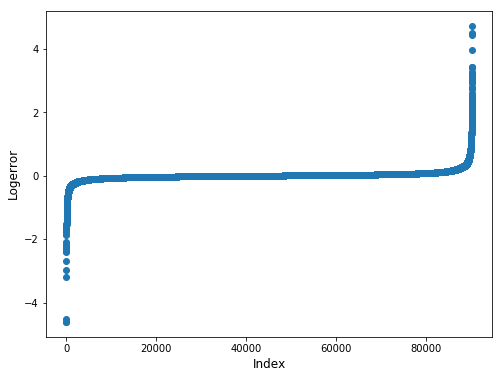

In [168]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df_temp.shape[0]), np.sort(train_df_temp.logerror.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Logerror', fontsize=12)
plt.show()

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecat

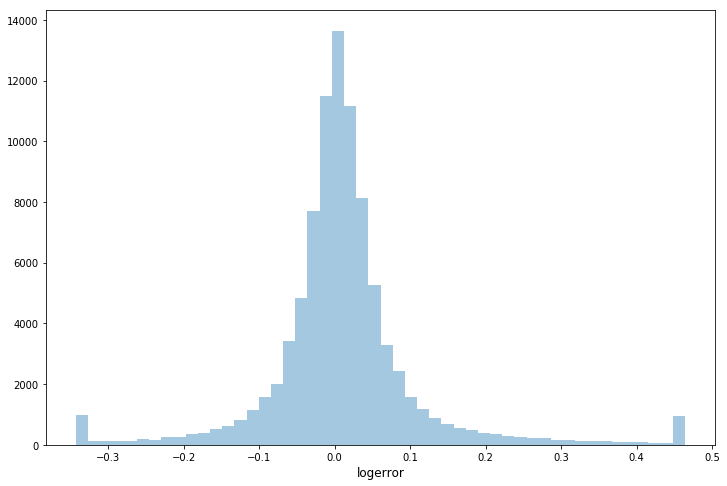

In [169]:
#Remove the outliers and do the histogram plot on the same.

ulimit = np.percentile(train_df_temp.logerror.values, 99)
llimit = np.percentile(train_df_temp.logerror.values, 1)
train_df_temp['logerror'].ix[train_df_temp['logerror']>ulimit] = ulimit
train_df_temp['logerror'].ix[train_df_temp['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df_temp.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

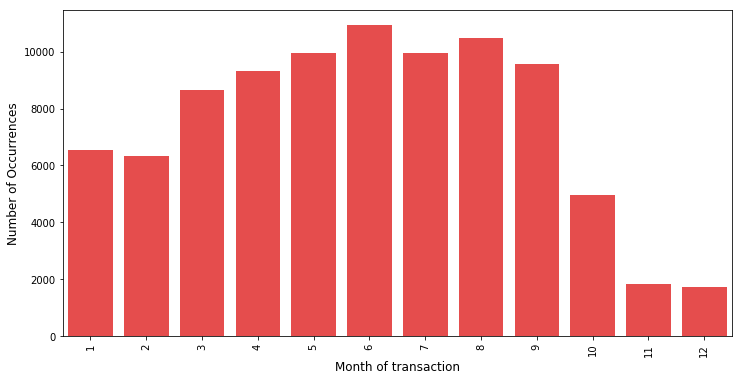

In [170]:
#train_df['transactiondate']
train_df_temp['transaction_month'] = train_df_temp['transactiondate'].dt.month

cnt_srs = train_df_temp['transaction_month'].value_counts()
cnt_srs
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='red')
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In the above graph, as we could see, we have shorter bars in the last three months since the train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

In [171]:
(train_df_temp['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

Most of the parcel ids are unique and appear only once in the dataset

# Exploring the properties_2016 file:

In [173]:
prop_df = pd.read_csv("../properties_2016.csv")
prop_df.shape

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\IPython\core\interactiveshell.py:2705: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

There are so many NaN values in the dataset.

Lets count the number of missing values in each column first.

In [174]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()

In [175]:
missing_df.columns = ['column_name', 'missing_count']

Lets begin with analysis of missing values to figure out a way to handle them

In [176]:
missing_df = missing_df.ix[missing_df['missing_count'] > 0]

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [177]:
missing_df = missing_df.sort_values(by='missing_count')

In [178]:
missing_df

,column_name,missing_count
35,rawcensustractandblock,11437
25,longitude,11437
24,latitude,11437
37,regionidcounty,11437
17,fips,11437
33,propertylandusetypeid,11437
52,assessmentyear,11439
5,bedroomcnt,11450
4,bathroomcnt,11462
40,roomcnt,11475


In [182]:
for clm, dtype in zip(prop_df.columns, prop_df.dtypes):
    if dtype == np.float64:
        prop_df[clm] = prop_df[clm].astype(np.float32)
train_df = prop_df.merge(train_df_temp, how='left', on='parcelid')

#del prop_df,train_df_temp
train_df = train_df[~ train_df['logerror'].isnull()].head(3000)
train_df.drop(['parcelid','transactiondate'], axis=1, inplace=True)

In [183]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column_Type"]
dtype_df.groupby("Column_Type").aggregate('count').reset_index()

,Column_Type,Count
0,float32,52
1,float64,2
2,object,5


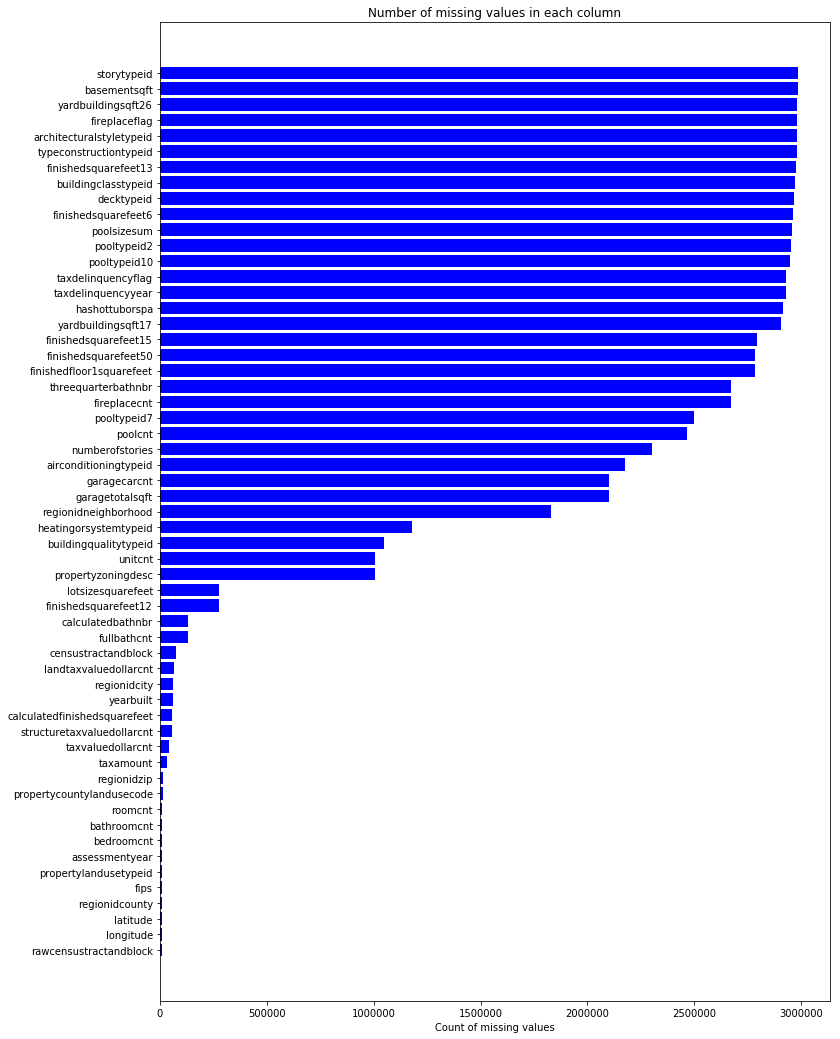

In [184]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [185]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 362 to 101365
Data columns (total 59 columns):
airconditioningtypeid           960 non-null float32
architecturalstyletypeid        2 non-null float32
basementsqft                    1 non-null float32
bathroomcnt                     3000 non-null float32
bedroomcnt                      3000 non-null float32
buildingclasstypeid             0 non-null float32
buildingqualitytypeid           1962 non-null float32
calculatedbathnbr               2958 non-null float32
decktypeid                      24 non-null float32
finishedfloor1squarefeet        226 non-null float32
calculatedfinishedsquarefeet    2980 non-null float32
finishedsquarefeet12            2854 non-null float32
finishedsquarefeet13            1 non-null float32
finishedsquarefeet15            114 non-null float32
finishedsquarefeet50            226 non-null float32
finishedsquarefeet6             11 non-null float32
fips                            3000 non-null

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

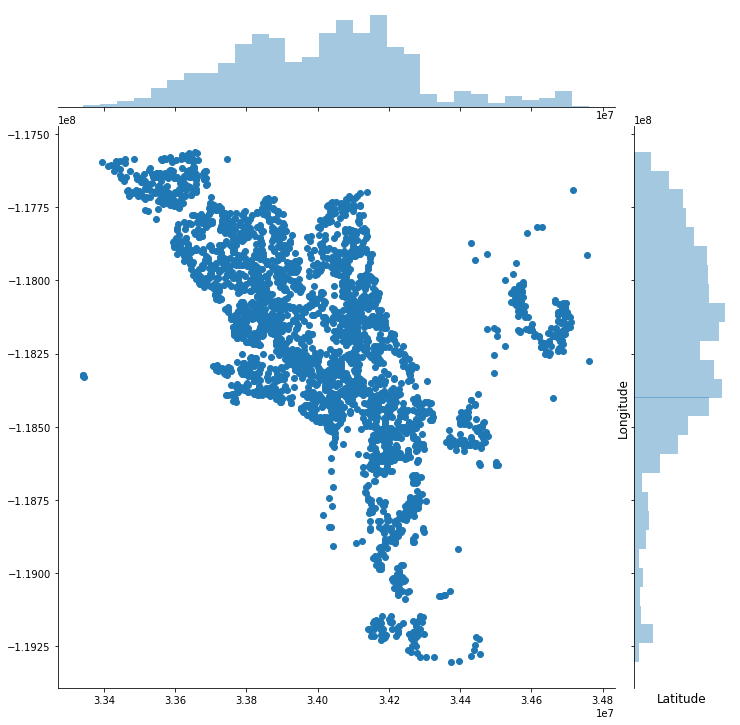

In [186]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.latitude.values, y=train_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

Lets merge the train and properties_2016 data file.

Lets count the number of NaN in the new merged file.

Lets find out the mean value for each variable.

In order to handle missing values, we'll replace NaN with mean value of that respective column

In [187]:
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'fullbathcnt','finishedsquarefeet15','finishedsquarefeet6','finishedsquarefeet50','calculatedbathnbr']
index = train_df.hashottuborspa.isnull()
#index.head()

train_df.loc[index,'hashottuborspa'] = "None"
print(train_df.hashottuborspa.value_counts())
print(train_df.pooltypeid10.value_counts())

dropcols.append('pooltypeid10')


index = train_df.pooltypeid2.isnull()
train_df.loc[index,'pooltypeid2']= 0


index = train_df.pooltypeid7.isnull()
train_df.loc[index,'pooltypeid7'] = 0


index = train_df.poolcnt.isnull()
train_df.loc[index,'poolcnt'] = 0


None    2933
True      67
Name: hashottuborspa, dtype: int64
1.0    39
Name: pooltypeid10, dtype: int64


In [188]:
print(train_df.poolsizesum.isnull().sum())
print(train_df.poolcnt.value_counts())

poolsizemedian = train_df.loc[train_df['poolcnt'] > 0, 'poolsizesum'].median()
train_df.loc[(train_df['poolcnt'] > 0) & (train_df['poolsizesum'].isnull()), 'poolsizesum'] = poolsizemedian
train_df.loc[train_df['poolcnt'] > 0, 'poolsizesum'] = 0

2965
0.0    2397
1.0     603
Name: poolcnt, dtype: int64


In [189]:
print(train_df.fireplaceflag.isnull().sum())
print(train_df.fireplacecnt.isnull().sum())

train_df['fireplaceflag'] = "No"
train_df.loc[train_df['fireplacecnt'] > 0,'fireplaceflag'] = "Yes"

index = train_df.fireplacecnt.isnull()
train_df.loc[index,'fireplacecnt'] = 0

2998
2687


In [190]:
index = train_df.taxdelinquencyflag.isnull()
train_df.loc[index, 'taxdelinquencyflag'] = "None"

In [191]:
print(train_df.garagecarcnt.isnull().sum())
print(train_df.garagetotalsqft.isnull().sum())

index = train_df.garagecarcnt.isnull()
train_df.loc[index, 'garagecarcnt'] = 0

index = train_df.garagetotalsqft.isnull()
train_df.loc[index, 'garagetotalsqft'] = 0

train_df['airconditioningtypeid'].value_counts()
index = train_df.airconditioningtypeid.isnull()
train_df.loc[index, 'airconditioningtypeid'] = 1

2056
2056


In [192]:
print(train_df['heatingorsystemtypeid'].value_counts())

index = train_df.heatingorsystemtypeid.isnull()
train_df.loc[index, 'heatingorsystemtypeid'] = 2

print(train_df['threequarterbathnbr'].value_counts())
index = train_df.threequarterbathnbr.isnull()
train_df.loc[index,'threequarterbathnbr'] = 1

2.0     1273
7.0      578
24.0      27
6.0       25
13.0       2
20.0       2
1.0        1
Name: heatingorsystemtypeid, dtype: int64
1.0    382
2.0      3
Name: threequarterbathnbr, dtype: int64


In [193]:
missing_values_prop = (train_df.isnull().sum()/len(train_df)).reset_index()
missing_values_prop.columns = ['Column_Name', 'proportion']
missing_values_prop.sort_values(by='proportion', ascending=False, inplace=True)

missing_prop_cols = missing_values_prop[missing_values_prop['proportion'] > 0.97].Column_Name.tolist()
dropcols = dropcols + missing_prop_cols
print(dropcols)
train_df.drop(dropcols, axis=1, inplace=True)

['finishedsquarefeet12', 'finishedsquarefeet13', 'fullbathcnt', 'finishedsquarefeet15', 'finishedsquarefeet6', 'finishedsquarefeet50', 'calculatedbathnbr', 'pooltypeid10', 'buildingclasstypeid', 'finishedsquarefeet13', 'basementsqft', 'storytypeid', 'yardbuildingsqft26', 'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 'decktypeid', 'pooltypeid10', 'taxdelinquencyyear']


In [194]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 362 to 101365
Data columns (total 43 columns):
airconditioningtypeid           3000 non-null float32
bathroomcnt                     3000 non-null float32
bedroomcnt                      3000 non-null float32
buildingqualitytypeid           1962 non-null float32
finishedfloor1squarefeet        226 non-null float32
calculatedfinishedsquarefeet    2980 non-null float32
fips                            3000 non-null float32
fireplacecnt                    3000 non-null float32
garagecarcnt                    3000 non-null float32
garagetotalsqft                 3000 non-null float32
hashottuborspa                  3000 non-null object
heatingorsystemtypeid           3000 non-null float32
latitude                        3000 non-null float32
longitude                       3000 non-null float32
lotsizesquarefeet               2680 non-null float32
poolcnt                         3000 non-null float32
poolsizesum                

In [195]:
from numpy.distutils.system_info import numpy_info
train_df.dropna(axis=0, how='any', subset=['latitude', 'longitude'], inplace=True)


def fillna_value_using_knn(df, base, target, fraction=1, thresold = 10, n_neighbors = 5):
    assert isinstance(base, list) or isinstance(base, np.ndarray) and isinstance(target, string)
    whole = [target] + base
    
    ms = df[target].isnull()
    notms = ~ms
    numms = ms.sum()
    #print(numms)
    enc = OneHotEncoder()
    x_target = df.loc[notms, whole].sample(frac=fraction)
    enc.fit(x_target[target].unique().reshape((-1, 1)))
    
    y = enc.transform(x_target[target].values.reshape((-1, 1))).toarray()
    x = x_target[base]
    
    print('knn neighbors')
    clf = KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(x, y)
    print(np.all(np.isfinite(df.loc[ms, base])))
    y_predict = clf.predict(df.loc[ms, base])
    #print(y_predict)
    
    numpredict = y_predict[:,0].sum()
    
    if numpredict/numms*100 < thresold:
        print('write result to df')
        df.loc[ms, target] = np.dot(y_predict, enc.active_features_)
        print('num of unpredicted data:', numpredict)
        return enc
    else:
        print('out of thresold')
        
        
def zoningcode2int(df, target):
    storenull = df[target].isnull()
    enc = LabelEncoder()
    df[target] = df[target].astype(str)

    print('fit and transform')
    df[target] = enc.fit_transform(df[target].values)
    print('num of categories: ', enc.classes_.shape)
    df.loc[storenull, target] = np.nan
    print('recover the nan value')
    return enc

In [196]:

fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='buildingqualitytypeid', fraction=0.15, n_neighbors=1)


#zoningcode2int(df=train_df, target='propertycountylandusecode')
#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='propertycountylandusecode', fraction=0.15, n_neighbors=1)

#zoningcode2int(df=train_df, target='propertyzoningdesc')
#fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='propertyzoningdesc', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(df=train_df,base=['latitude', 'longitude'], target='regionidcity', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='regionidneighborhood', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='regionidzip', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='unitcnt', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='yearbuilt', fraction=0.15, n_neighbors=1)

fillna_value_using_knn(df=train_df, base=['latitude', 'longitude'], target='lotsizesquarefeet', fraction=0.15, n_neighbors=1)

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\preproce

knn neighbors
True
write result to df
num of unpredicted data: 5.0
knn neighbors
True
write result to df
num of unpredicted data: 0.0


knn neighbors
True
write result to df
num of unpredicted data: 8.0
knn neighbors
True
write result to df


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\utils\de

num of unpredicted data: 0.0
knn neighbors
True
out of thresold
knn neighbors
True
write result to df
num of unpredicted data: 1.0
knn neighbors


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


True


write result to df
num of unpredicted data: 0.0


C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)

In [197]:
train_df.loc[(train_df['finishedfloor1squarefeet'].isnull()) & (train_df['numberofstories'] == 1), 'finishedfloor1squarefeet'] = train_df.loc[(train_df['finishedfloor1squarefeet'].isnull()) & (train_df['numberofstories'] == 1), 'calculatedfinishedsquarefeet']

droprows = train_df.loc[train_df['calculatedfinishedsquarefeet'] < train_df['finishedfloor1squarefeet']].index
train_df = train_df.drop(droprows)

train_df.loc[train_df.taxvaluedollarcnt.isnull(), 'taxvaluedollarcnt'] = train_df.loc[train_df.taxvaluedollarcnt.isnull(), 'taxamount']
train_df.loc[train_df.landtaxvaluedollarcnt.isnull(), 'landtaxvaluedollarcnt'] = train_df.loc[train_df.landtaxvaluedollarcnt.isnull(), 'taxamount']

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


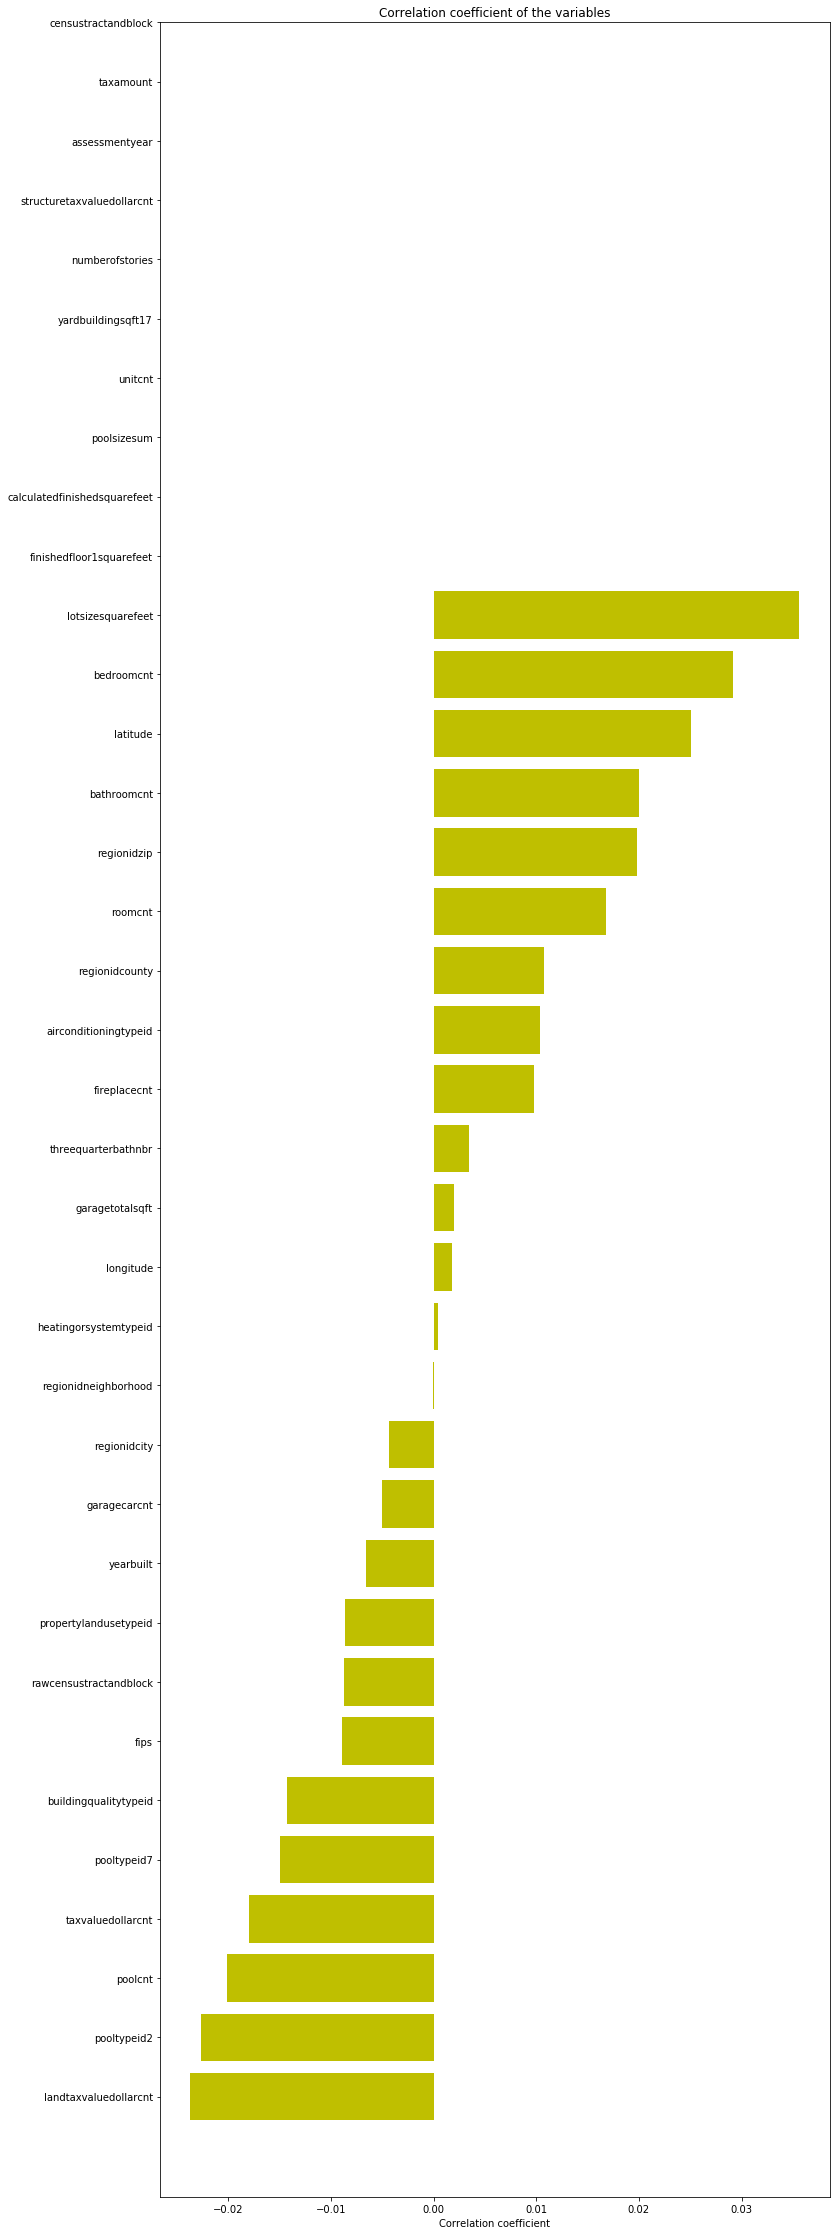

In [198]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float32']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
#train_df.head()
#corr_df.head()
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

Lets figure out variables with high correlation and then do some analysis on them.

In [199]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
33,landtaxvaluedollarcnt,-0.023694
16,pooltypeid2,-0.022630
14,poolcnt,-0.020159
31,taxvaluedollarcnt,-0.018024
17,pooltypeid7,-0.014997
3,buildingqualitytypeid,-0.014235
11,latitude,0.025052
2,bedroomcnt,0.029155
13,lotsizesquarefeet,0.035608


In [200]:
def variation(col, col_name, title):
    ulimit = np.percentile(col.values, 99.5)
    llimit = np.percentile(col.values, 0.5)
    col.ix[col>ulimit] = ulimit
    col.ix[col<llimit] = llimit

    plt.figure(figsize=(12,12))
    sns.jointplot(x=col.values, y=train_df.logerror.values, size=10, color='blue')
    plt.ylabel('Log Error', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.title(title, fontsize=15)
    plt.show()

Finished Square Feet 12

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:5: 

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

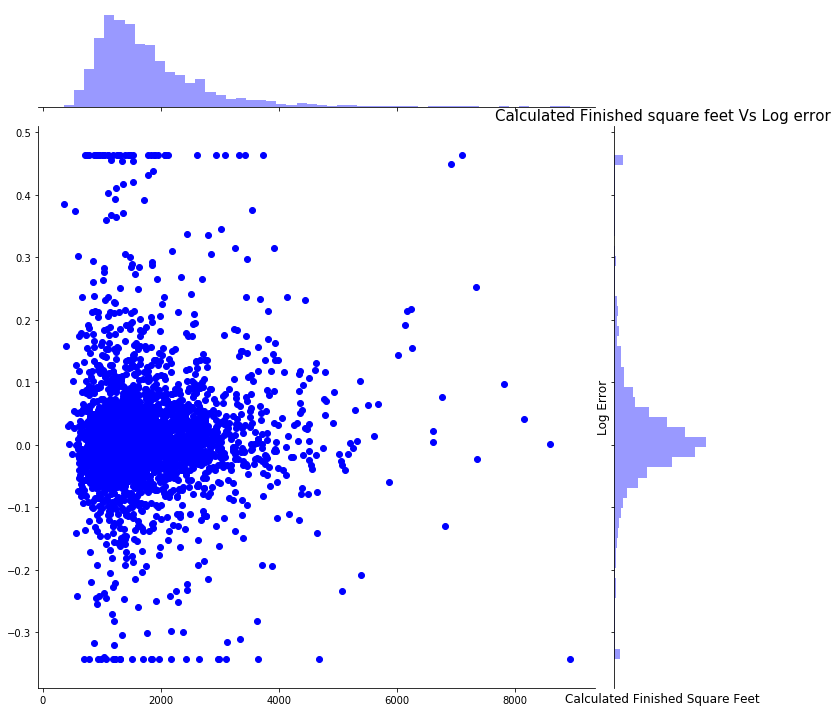

In [201]:
variation(train_df.calculatedfinishedsquarefeet, 'Calculated Finished Square Feet', "Calculated Finished square feet Vs Log error")

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:5: 

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x864 with 0 Axes>

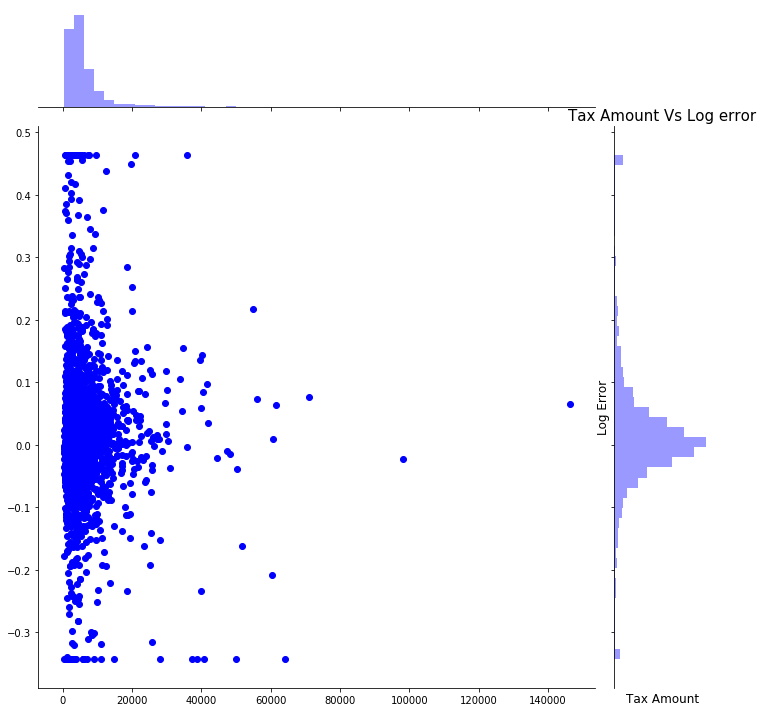

In [202]:
variation(train_df.taxamount, 'Tax Amount', "Tax Amount Vs Log error")

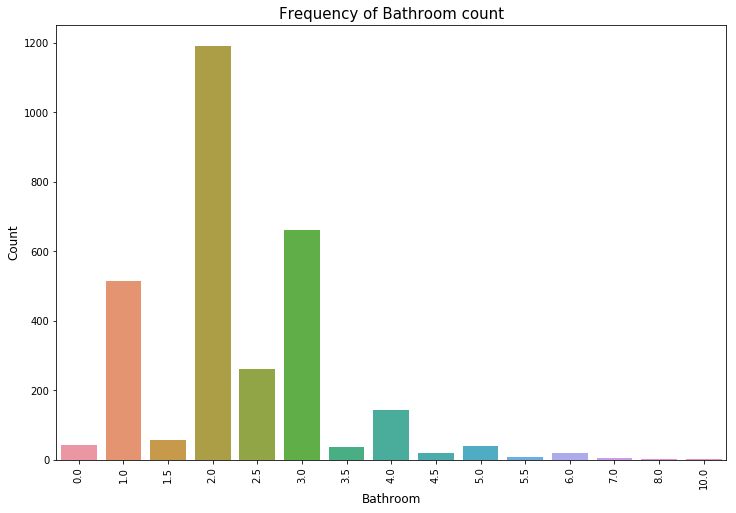

In [203]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

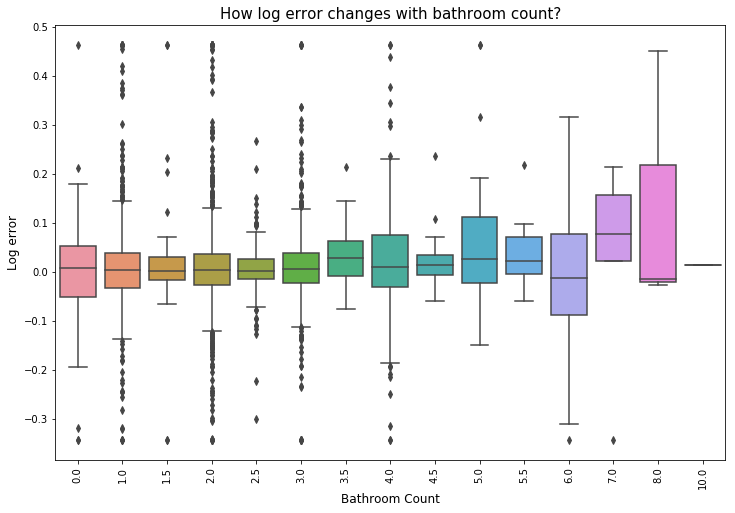

In [204]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

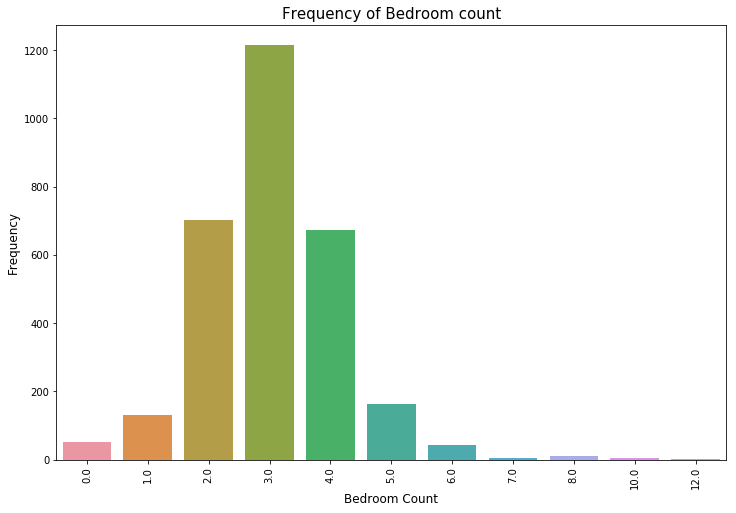

In [205]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Akshay\PycharmProjects\first_project\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an 

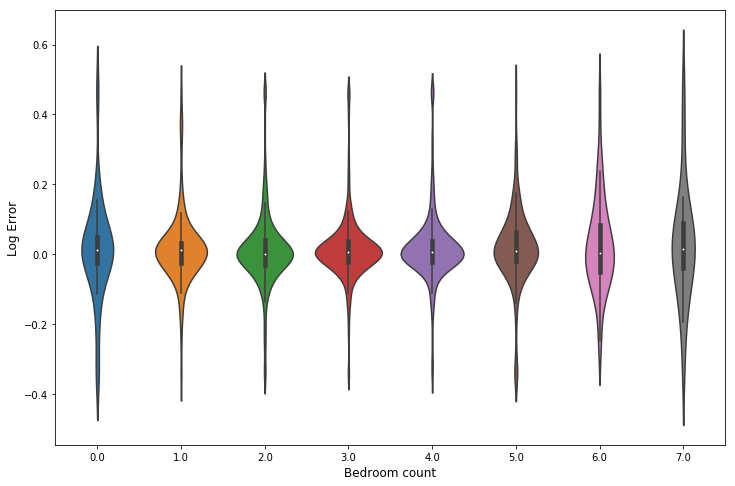

In [146]:
train_df['bedroomcnt'].ix[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

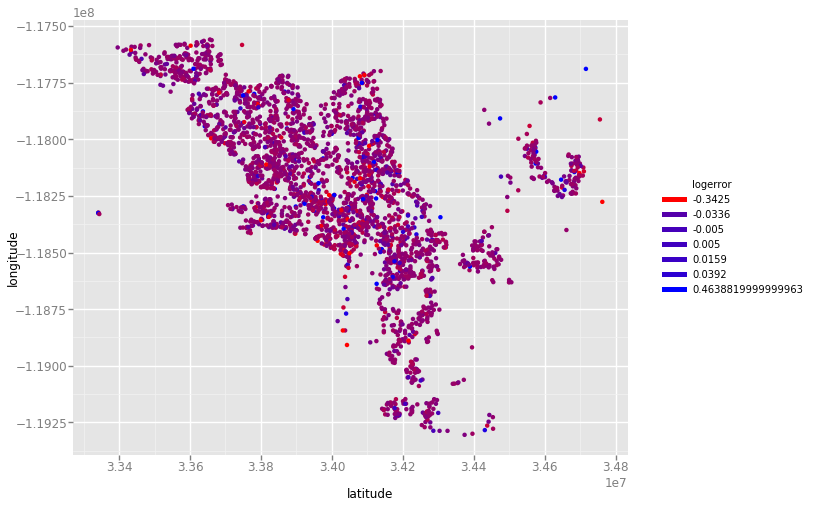

<ggplot: (-9223371908896228955)>

In [206]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

In [209]:
sample_df= train_df.isnull().sum(axis=0).reset_index()
sample_df.columns = ['column_name','cnt']
sample_df = sample_df.loc[sample_df['cnt']>=0]
print(sample_df.column_name.values)

['airconditioningtypeid' 'bathroomcnt' 'bedroomcnt'
 'buildingqualitytypeid' 'finishedfloor1squarefeet'
 'calculatedfinishedsquarefeet' 'fips' 'fireplacecnt' 'garagecarcnt'
 'garagetotalsqft' 'hashottuborspa' 'heatingorsystemtypeid' 'latitude'
 'longitude' 'lotsizesquarefeet' 'poolcnt' 'poolsizesum' 'pooltypeid2'
 'pooltypeid7' 'propertycountylandusecode' 'propertylandusetypeid'
 'propertyzoningdesc' 'rawcensustractandblock' 'regionidcity'
 'regionidcounty' 'regionidneighborhood' 'regionidzip' 'roomcnt'
 'threequarterbathnbr' 'unitcnt' 'yardbuildingsqft17' 'yearbuilt'
 'numberofstories' 'fireplaceflag' 'structuretaxvaluedollarcnt'
 'taxvaluedollarcnt' 'assessmentyear' 'landtaxvaluedollarcnt' 'taxamount'
 'taxdelinquencyflag' 'censustractandblock' 'logerror' 'transaction_month']
